## Case study: are firstborn babies born earlier?

Source: Think Stats

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf

sns.set_style("whitegrid")

%config InlineBackend.figure_format ='retina'

In [4]:
# replace with version in helpers and adapt code below

def read_pregnancy_data():
    """Load pregnancy data used in ThinkStats.

    Assumes that pregnancy lengths of < 20 and > 45 weeks are data errors.
    Converts birghweight from pounds to kilograms.
    """

    def extract_idx(s, start, end):
        """Returns cleaned up version of s[start:end]."""
        return (
            s.str[start:end]
            .replace("^\s*$", np.nan, regex=True)
            .str.strip()
            .astype("float")
        )

    fp = "https://greenteapress.com/thinkstats/2002FemPreg.dat.gz"
    fb_labs = {True: "Firstborn", False: "Others"}
    return (
        pd.read_table(fp, header=None, names=["line"])
        .assign(
            caseid=lambda df: df.line.str[:12].str.strip().astype("int"),
            babysex=lambda df: extract_idx(df.line, 55, 56),
            birthord=lambda df: extract_idx(df.line, 277, 279),
            firstbornn=lambda df: df.birthord.eq(1),
            firstborn=lambda df: df.firstbornn.map(fb_labs).astype("category"),
            prglength=lambda df: extract_idx(df.line, 274, 276),
            birthwgt=lambda df: extract_idx(df.line, 56, 58) / 2.205,
            outcome=lambda df: extract_idx(df.line, 276, 277),
            agepreg=lambda df: extract_idx(df.line, 283, 285),
        )
        .drop(columns="line")
        .loc[lambda df:
             df.prglength.between(20, 45)
             & df.birthwgt.between(1, 5)
             & df.agepreg.between(16, 50)
             & df.outcome.eq(1)
        ]
    )


df = read_pregnancy_data()
df.head(3)

,caseid,babysex,birthord,firstbornn,firstborn,prglength,birthwgt,outcome,agepreg
0,1,1.0,1.0,True,Firstborn,39.0,3.628118,1.0,33.0
1,1,2.0,2.0,False,Others,39.0,3.174603,1.0,39.0
3,2,2.0,2.0,False,Others,39.0,3.174603,1.0,17.0


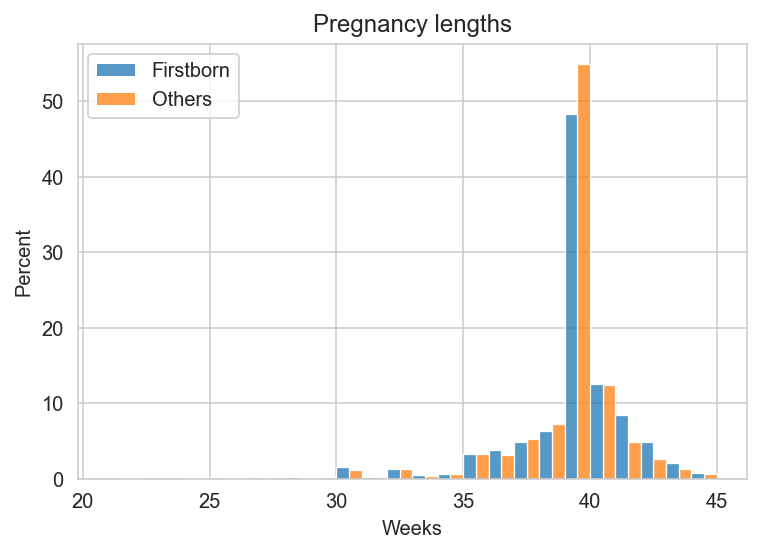

In [93]:
def firstborn_pmfs(data):
    ax = sns.histplot(
        data=data,
        x="prglength",
        hue="firstborn",
        multiple="dodge",
        stat="percent",
        common_norm=False,
        binwidth=1,
    )
    ax.set(xlabel="Weeks", title="Pregnancy lengths")
    ax.legend_.set_title(None)


firstborn_pmfs(df)

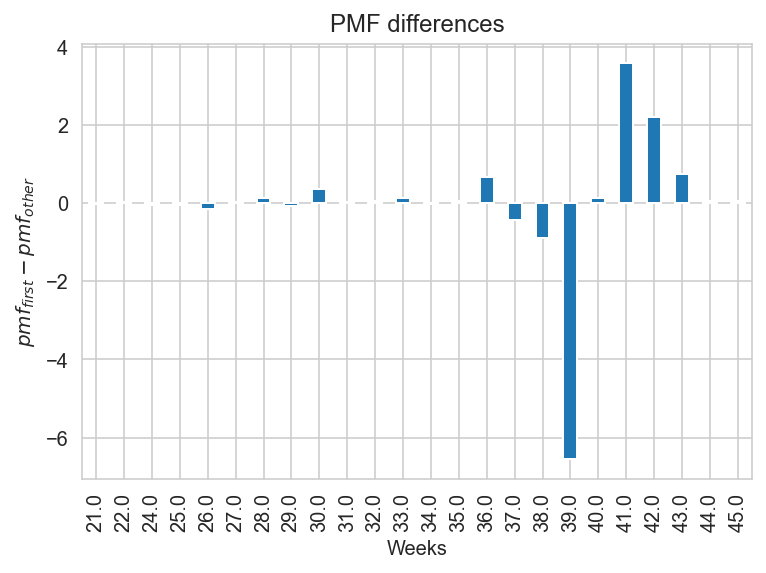

In [94]:
def firstborn_dpmfs():
    counts = df.groupby(["prglength", "firstborn"]).size().unstack().fillna(0)
    probs = counts / counts.sum() * 100
    diffs = probs.Firstborn - probs.Others
    return diffs.plot(
        kind="bar",
        xlabel="Weeks",
        ylabel="$pmf_{first} - pmf_{other}$",
        title="PMF differences",
    )


firstborn_dpmfs();

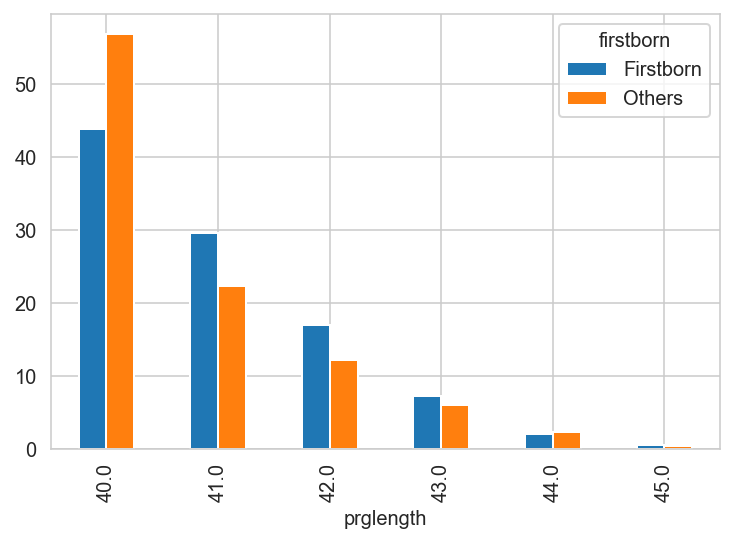

In [95]:
def conditional_pmf(current_wk=0):
    counts = df.groupby(["prglength", "firstborn"]).size().unstack().fillna(0)
    subset = counts.loc[current_wk:]
    return subset / subset.sum() * 100


conditional_pmf(40).plot(kind="bar");

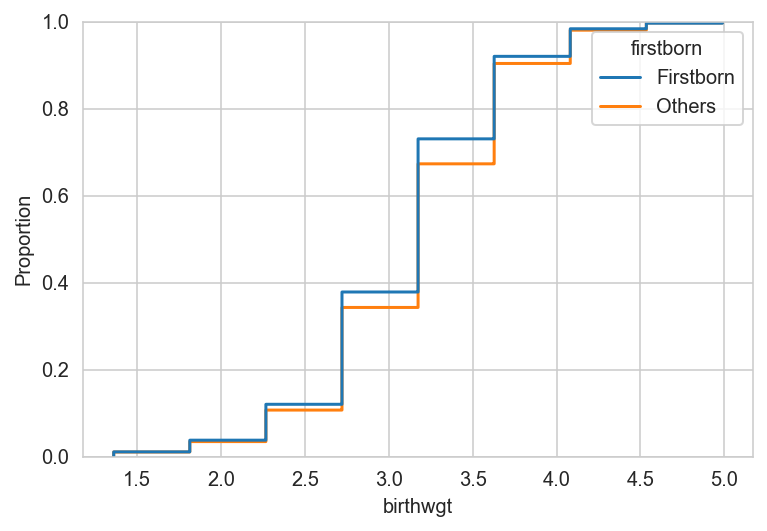

In [96]:
sns.ecdfplot(data=df, x="birthwgt", hue="firstborn");

## Distributions

### Exponential distribution

- CDF is $CDF(x) = 1 - e^{-\lambda x}$

In [98]:
pal = 'Paired'
print(sns.color_palette(pal).as_hex())
sns.color_palette(pal)


# colors = sns.color_palatte('Paired')[:4]

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

### Baby weights

First born babies tend to be leighter than others

In [104]:
df.groupby('firstborn').birthwgt.mean()

firstborn
Firstborn    3.093493
Others       3.151810
Name: birthwgt, dtype: float64

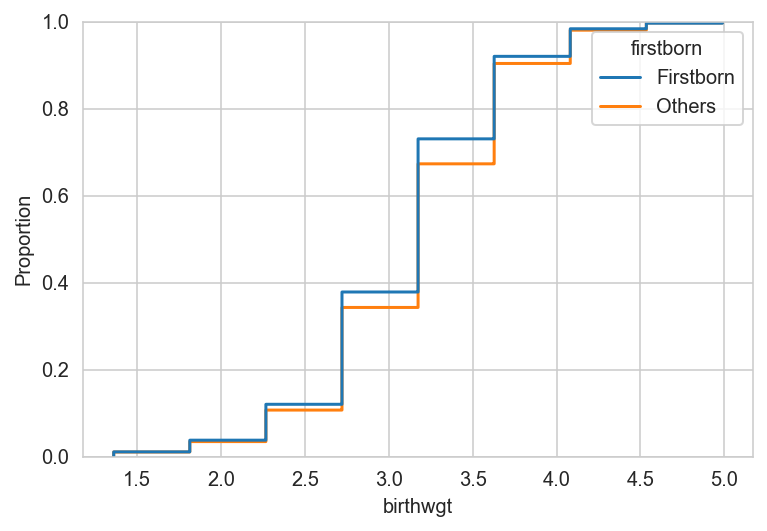

In [107]:
sns.ecdfplot(data=df, x='birthwgt', hue='firstborn');

Is that because mothers of first born babies are younger? For this to be the case, it wound need to be the case that a) mothers of first born babies are younger (which is necessarily true) and b) that babies of younger mothers are also lighter.

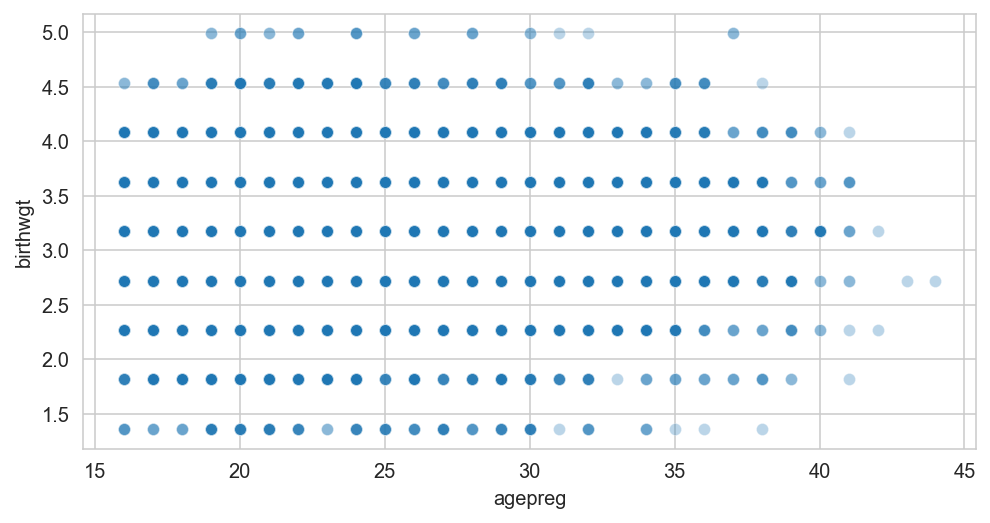

In [108]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.scatterplot(data=df, x='agepreg', y='birthwgt', alpha=0.3, ax=ax);

In [110]:
df[['agepreg', 'birthwgt']].corr()

,agepreg,birthwgt
agepreg,1.000000,0.076252
birthwgt,0.076252,1.000000


In [102]:
m = smf.ols('birthwgt ~ agepreg', data=df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:               birthwgt   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     51.27
Date:                Mon, 30 May 2022   Prob (F-statistic):           8.71e-13
Time:                        15:56:39   Log-Likelihood:                -7590.2
No. Observations:                8768   AIC:                         1.518e+04
Df Residuals:                    8766   BIC:                         1.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9243      0.029    102.215      0.0